In [524]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import linear_model
import math

from sklearn import preprocessing
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error as MSE
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)
import warnings
warnings.filterwarnings('ignore')

In [525]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

In [526]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

<AxesSubplot:>

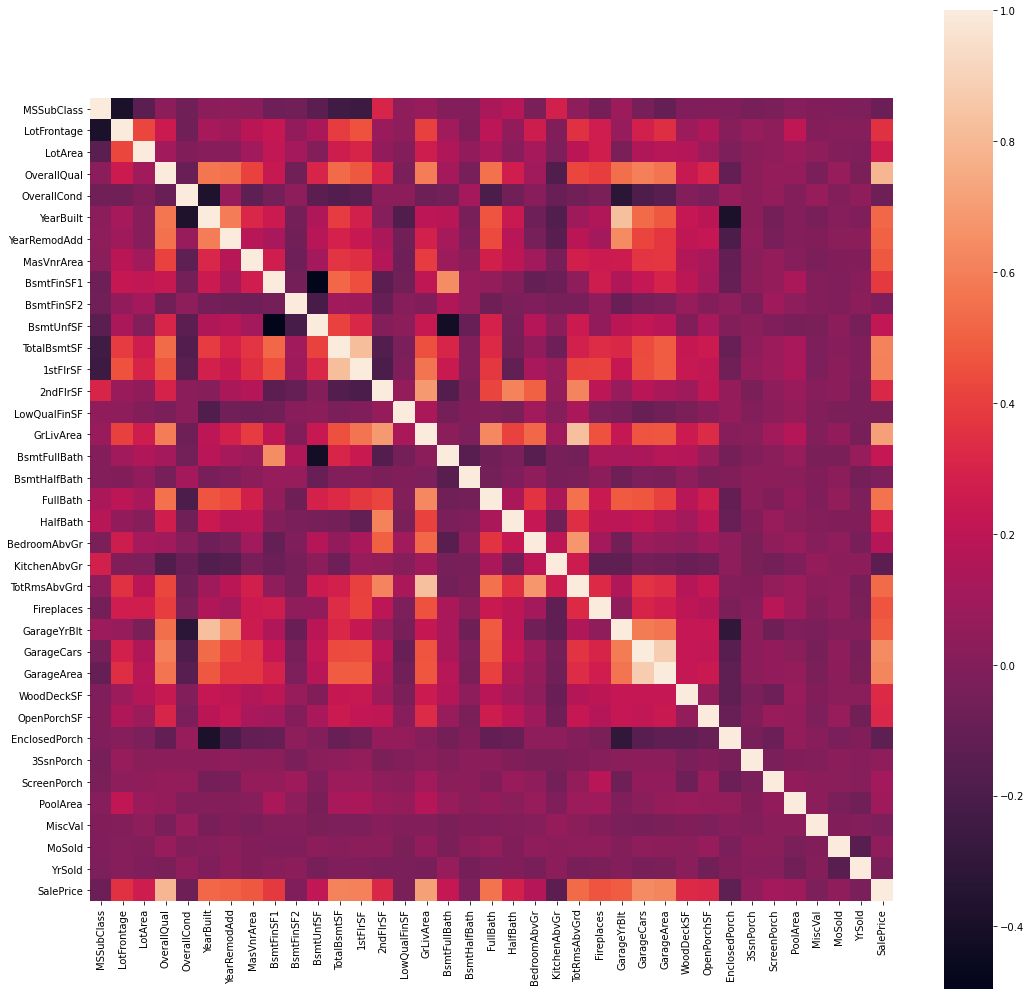

In [527]:
# Corr for original train data
temp = []
for index, val in train.dtypes.items():
    if index != 'Id':
        temp.append(index)
heatmapTemp = train[temp]
heatmapData = heatmapTemp.corr()
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(heatmapData, vmax=1, square=True)

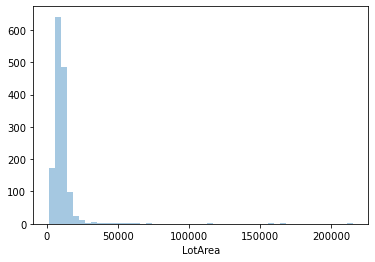

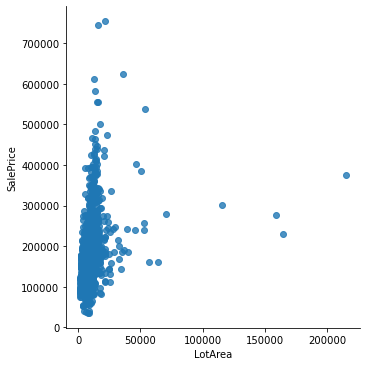

In [528]:
sns.distplot(train['LotArea'], kde=False)
plt.show()

sns.lmplot('LotArea', 'SalePrice', train, fit_reg=False)
plt.show()

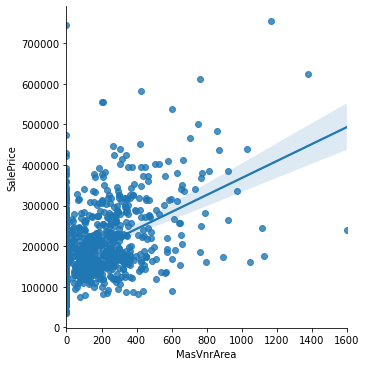

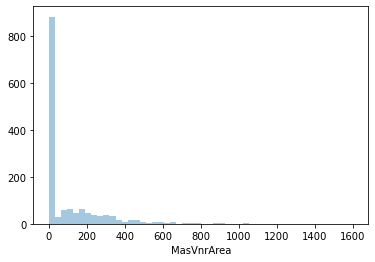

In [529]:
sns.lmplot('MasVnrArea', 'SalePrice', train, fit_reg=True)
plt.show()
sns.distplot(train['MasVnrArea'], kde=False)
plt.show()

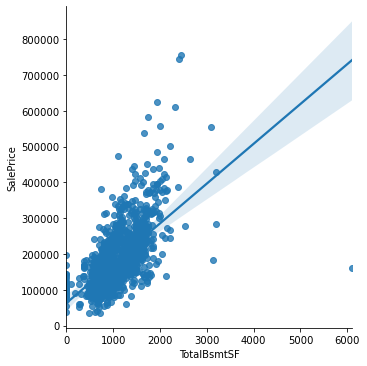

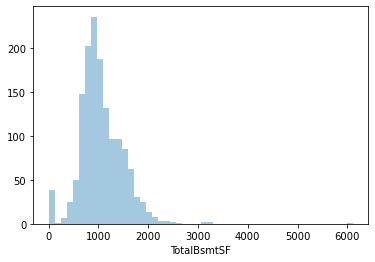

In [530]:
sns.lmplot('TotalBsmtSF', 'SalePrice', train, fit_reg=True)
plt.show()
sns.distplot(train['TotalBsmtSF'], kde=False)
plt.show()

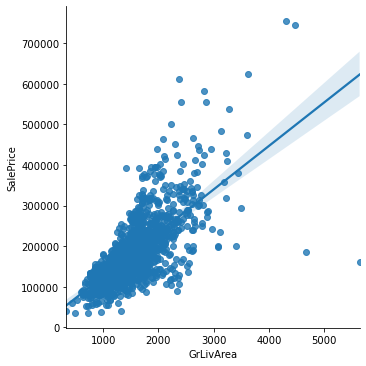

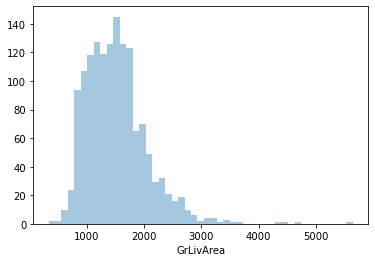

In [531]:
sns.lmplot('GrLivArea', 'SalePrice', train, fit_reg=True)
plt.show()
sns.distplot(train['GrLivArea'], kde=False)
plt.show()

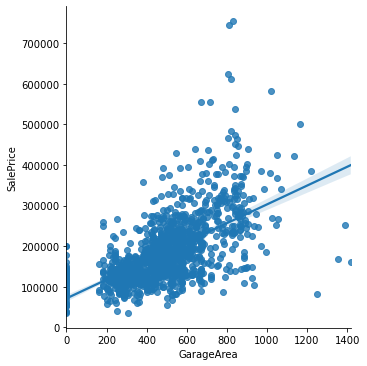

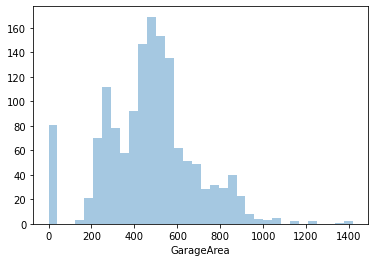

In [532]:
sns.lmplot('GarageArea', 'SalePrice', train, fit_reg=True)
plt.show()
sns.distplot(train['GarageArea'], kde=False)
plt.show()

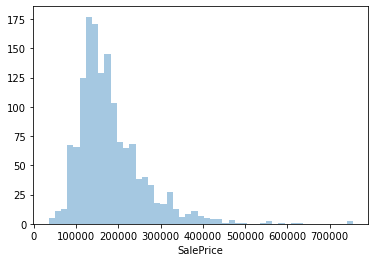

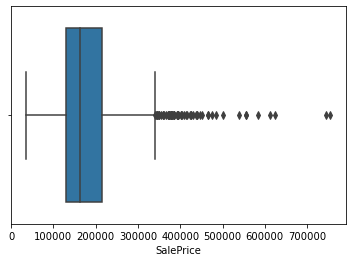

In [533]:
sns.distplot(train['SalePrice'], kde=False)
plt.show()
sns.boxplot(train['SalePrice'])
plt.show()

In [534]:
# Tableau 分析结果如下
# 地理位置影响价格
# 2004年之后建造的房子价格有明显升高
# 翻修年份长短貌似对价格影响不大
# 价格分布: Noridge 有两个异常值
#          Northridge，Northridge Heights和Stone Brook平均价格较高


In [535]:
# Delete two extreme values
train = train.drop((train.query("SalePrice > 700000")).index)

In [536]:
train1 = train.copy(deep=True)
test1 = test.copy(deep=True)

In [537]:
total = pd.concat([train1, test1], axis=0)
saleprice = train['SalePrice'].values.reshape(-1,1)
del total['SalePrice']
del total['Id']

In [538]:
# House age
total['HouseAge'] = total.apply(lambda x:2019 - x['YearBuilt'], axis=1)

# Recent live years
total['RecentLivYrs'] = total.apply(lambda x:2019 - x['YrSold'], axis=1)

In [539]:
total['RebuiltAge'] = total.apply(lambda x:x['YearRemodAdd'] - x['YearBuilt'], axis=1)

In [540]:
total['GarageYrBlt'] = total['GarageYrBlt'].astype('str')
total['GarageYrBlt'] = total.apply(lambda x: x['YearBuilt'] if x['GarageYrBlt'] == 'nan' else x['GarageYrBlt'], axis=1)
total['GarageYrBlt'] = total['GarageYrBlt'].astype('float64')
total['GarageYrBlt'] = total['GarageYrBlt'].astype('int')

total['GarageAge'] = total.apply(lambda x:2019 - x['GarageYrBlt'], axis=1)

In [541]:
# Overall score
# total['OverallScore'] = total.apply(lambda x : (x['OverallQual'] + x['OverallCond'])/2, axis=1)

In [542]:
# Delete rich null values and few deviation columns
del total['Alley']
del total['PoolQC']
del total['Fence']
del total['MiscFeature']
del total['FireplaceQu']
del total['Street']
del total['Utilities']

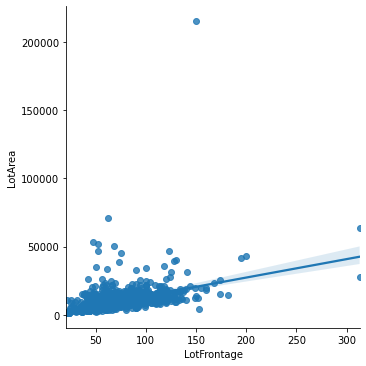

In [543]:
# Process null value for LotFrontage
sns.lmplot('LotFrontage', 'LotArea', total, fit_reg=True)
plt.show()

na_rows = total[total['LotFrontage'].isnull()]
temp = total[total['LotFrontage'].notnull()]

model = linear_model.LinearRegression()
model.fit(temp['LotArea'].values.reshape(-1,1), temp['LotFrontage'].values.reshape(-1,1))
# lotfrt = model.predict(na_rows['LotArea'].values.reshape(-1,1))

total['LotFrontage'] = total.apply(lambda x : x['LotArea']*model.coef_[0][0]+model.intercept_[0] if math.isnan(x['LotFrontage']) else x['LotFrontage'], axis=1)

In [544]:
# Process MSZoning
# 根据观察缺失数据的Neighborhood为IDOTRR和Mitchel，训练集中这两个区域的MSZoning值为C,RL,RM。由于lotArea较大，所以大概率为RL。
total['MSZoning'].fillna('RL', inplace=True)

In [545]:
# Process Exterior1st and Exterior1st
total['Exterior1st'].fillna('Wd Sdng', inplace=True)
total['Exterior2nd'].fillna('Wd Sdng', inplace=True)

In [546]:
# Process MasVnrType
t1 = total.copy(deep=True)
dummies = ['LotShape', 
           'LandContour', 
           'LotConfig', 
           'LandSlope', 
           'Neighborhood', 
           'Condition1', 
           'Condition2', 
           'BldgType', 
           'HouseStyle',
           'RoofStyle',
           'RoofMatl', 
           'Exterior1st',
           'Exterior2nd']
for feature in dummies:
    dummy_features = pd.get_dummies(t1[feature], prefix='mastype')
    for dummy in dummy_features:
        t1[dummy] = dummy_features[dummy]
        
filter_col = [col for col in t1 if col.startswith('mastype')]
t1_1 = t1[t1['MasVnrType'].notna()]
t1_2 = t1[t1['MasVnrType'].isna()]
MasVnrType = {'BrkFace':1, 'None':2, 'BrkCmn':3, 'Stone':4}
MasVnrType1 = {v: k for k, v in MasVnrType.items()}
t1_1['MasVnrType'] = t1_1['MasVnrType'].apply(lambda x : MasVnrType[x])

clf = DecisionTreeClassifier()
clf = clf.fit(t1_1[filter_col].values, t1_1['MasVnrType'].values.reshape(-1,1))
y_pred = clf.predict(t1_2[filter_col].values)

# Assign the predicted values to NA values
total.loc[total.MasVnrType.isna(), ['MasVnrType']] = y_pred

total['MasVnrType'] = total['MasVnrType'].apply(lambda x : MasVnrType1[x] if x in [1,2,3,4] else x)

In [547]:
# Process MasVnrArea
mean1 = total.query("MasVnrType == 'BrkFace'")['MasVnrArea'].mean()
mean2 = total.query("MasVnrType == 'Stone'")['MasVnrArea'].mean()
total['MasVnrArea'].fillna(-1, inplace=True)
total['MasVnrArea'] = total.apply(lambda x : 0 if x['MasVnrType'] == 'None' else x['MasVnrArea'], axis=1)
total['MasVnrArea'] = total.apply(lambda x : mean1 if x['MasVnrType'] == 'BrkFace' and x['MasVnrArea'] == -1 else x['MasVnrArea'], axis=1)
total['MasVnrArea'] = total.apply(lambda x : mean2 if x['MasVnrType'] == 'Stone' and x['MasVnrArea'] == -1 else x['MasVnrArea'], axis=1)

In [548]:
# Process Bsmt features
total['TotalBsmtSF'].fillna(0, inplace=True)
total['BsmtFinSF1'] = total.apply(lambda x : 0 if x['TotalBsmtSF'] == 0 else x['BsmtFinSF1'], axis=1)
total['BsmtFinSF2'] = total.apply(lambda x : 0 if x['TotalBsmtSF'] == 0 else x['BsmtFinSF2'], axis=1)
total['BsmtUnfSF'] = total.apply(lambda x : 0 if x['TotalBsmtSF'] == 0 else x['BsmtUnfSF'], axis=1)
total['BsmtQual'].fillna('unkown', inplace=True)
total['BsmtCond'].fillna('unkown', inplace=True)
total['BsmtExposure'].fillna('unkown', inplace=True)
total['BsmtFinType1'].fillna('unkown', inplace=True)
total['BsmtFinType2'].fillna('unkown', inplace=True)
total['BsmtFullBath'].fillna(0, inplace=True)
total['BsmtHalfBath'].fillna(0, inplace=True)

In [549]:
total['Electrical'].fillna('SBrkr', inplace=True)
total['KitchenQual'].fillna('TA', inplace=True)
total['Functional'].fillna('Typ', inplace=True)

In [550]:
# Process Garage features
total['GarageCars'].fillna(0, inplace=True)
total['GarageArea'].fillna(0, inplace=True)
total['GarageType'].fillna('unkown', inplace=True)
total['GarageFinish'].fillna('unkown', inplace=True)
total['GarageQual'].fillna('unkown', inplace=True)
total['GarageCond'].fillna('unkown', inplace=True)

In [551]:
# Process SaleType
total['SaleType'].fillna('WD', inplace=True)

In [552]:
# Nb average price
# df1 = train.groupby(['Neighborhood']).agg({'GrLivArea':'sum', 'SalePrice':'sum'})
# df1 = df1.reset_index()
# df1['AvgPrice'] = df1.SalePrice/df1.GrLivArea
# df1.drop(['GrLivArea', 'SalePrice'], inplace=True, axis=1)
# total = pd.merge(total, df1, on=['Neighborhood'])

In [553]:
# Print all the columns contain null value
null_cols = total.isnull().any()
for index, val in null_cols.items():
    if val:
        num = total[index].isnull().sum()
        print(index, '/',num, '/',num/total[index].shape[0])

In [554]:
# 处理离散特征
dummies = ['LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'CentralAir']
for feature in dummies:
    dummy_features = pd.get_dummies(total[feature], prefix=feature)
    total = pd.concat([total, dummy_features], axis=1)
    del total[feature]

MSSubClass = {60:15, 120:14, 75:13, 20:12, 80:11,
              70:10, 40:9, 85:8, 50:7, 160:6,
              90:5, 190:4, 45:3, 180:2, 30:1, 150:7}
total['MSSubClass'] = total['MSSubClass'].apply(lambda x : MSSubClass[x])

MSZoning = {'FV':5, 'RL':4, 'RH':3, 'RM':2, 'C (all)':1}
total['MSZoning'] = total['MSZoning'].apply(lambda x : MSZoning[x])

Neighborhood = {'NoRidge':25, 'NridgHt':24, 'StoneBr':23, 'Timber':22, 'Veenker':21,
               'Somerst':20,'ClearCr':19,'Crawfor':18,'CollgCr':17,'Blmngtn':16,
               'Gilbert':15,'NWAmes':14,'SawyerW':13,'Mitchel':12,'NAmes':11,
               'NPkVill':10,'SWISU':9,'Blueste':8,'Sawyer':7,'OldTown':6,
               'Edwards':5,'BrkSide':4,'BrDale':3,'IDOTRR':2,'MeadowV':1,}
total['Neighborhood'] = total['Neighborhood'].apply(lambda x : Neighborhood[x])

Condition1 = {'PosA':3, 'PosN':3, 'RRNn':3, 'RRNe':2, 'Norm':2, 'RRAn':2, 'Feedr':1, 'RRAe':1, 'Artery':1}
total['Condition1'] = total['Condition1'].apply(lambda x : Condition1[x])

Condition2 = {'PosA':4, 'PosN':3, 'RRAe':2, 'Norm':2, 'RRAn':1, 'Feedr':1, 'Artery':1, 'RRNn':1}
total['Condition2'] = total['Condition2'].apply(lambda x : Condition2[x])

BldgType = {'1Fam':2, 'TwnhsE':2, 'Twnhs':1, 'Duplex':1, '2fmCon':1}
total['BldgType'] = total['BldgType'].apply(lambda x : BldgType[x])

HouseStyle = {'2.5Fin':8, '2Story':7, '1Story':6, 'SLvl':5, '2.5Unf':4, '1.5Fin':3, 'SFoyer':2, '1.5Unf':1}
total['HouseStyle'] = total['HouseStyle'].apply(lambda x : HouseStyle[x])

RoofStyle = {'Shed':6, 'Hip':5, 'Flat':4, 'Mansard':3, 'Gable':2, 'Gambrel':1}
total['RoofStyle'] = total['RoofStyle'].apply(lambda x : RoofStyle[x])

RoofMatl = {'WdShngl':5, 'Membran':4, 'WdShake':4, 'Tar&Grv':3, 'Metal':3, 'CompShg':3, 'ClyTile':2, 'Roll':1}
total['RoofMatl'] = total['RoofMatl'].apply(lambda x : RoofMatl[x])

Exterior1st = {'ImStucc':5, 'Stone':5, 'CemntBd':5, 'VinylSd':5, 
               'BrkFace':4, 'Plywood':4, 'HdBoard':3, 'Stucco':3, 
               'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'AsbShng':2,
              'CBlock':2, 'AsphShn':2, 'BrkComm':1}
total['Exterior1st'] = total['Exterior1st'].apply(lambda x : Exterior1st[x])

Exterior2nd = {'Other':7, 'ImStucc':6, 'CmentBd':5, 'VinylSd':4, 
               'BrkFace':3, 'Plywood':2, 'HdBoard':2, 'Wd Shng':2,
              'Stone':2, 'Stucco':2, 'MetalSd':2, 'Wd Sdng':2,
              'AsphShn':2, 'Brk Cmn':1, 'AsbShng':1, 'CBlock':1}
total['Exterior2nd'] = total['Exterior2nd'].apply(lambda x : Exterior2nd[x])

MasVnrType = {'Stone':4, 'BrkFace':3, 'None':2, 'BrkCmn':1}
total['MasVnrType'] = total['MasVnrType'].apply(lambda x : MasVnrType[x])

ExterQual = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
total['ExterQual'] = total['ExterQual'].apply(lambda x : ExterQual[x])

ExterCond = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
total['ExterCond'] = total['ExterCond'].apply(lambda x : ExterCond[x])

Foundation = {'PConc':6, 'Wood':5, 'Stone':4, 'CBlock':3, 'BrkTil':2, 'Slab':1}
total['Foundation'] = total['Foundation'].apply(lambda x : Foundation[x])

BsmtQual = {'Ex':6, 'Gd':5, 'TA':4, 'Fa':3, 'unkown':3, 'Po':2, 'NA':1}
total['BsmtQual'] = total['BsmtQual'].apply(lambda x : BsmtQual[x])

BsmtCond = {'Ex':6, 'Gd':5, 'TA':4, 'Fa':3, 'unkown':3, 'Po':2, 'NA':1}
total['BsmtCond'] = total['BsmtCond'].apply(lambda x : BsmtCond[x])

BsmtExposure = {'Gd':5, 'Av':4, 'Mn':3, 'No':2, 'NA':1, 'unkown':1}
total['BsmtExposure'] = total['BsmtExposure'].apply(lambda x : BsmtExposure[x])

BsmtFinType1 = {'GLQ':7, 'ALQ':6, 'BLQ':5, 'Rec':4, 'LwQ':3, 'Unf':2, 'NA':1, 'unkown':3}
total['BsmtFinType1'] = total['BsmtFinType1'].apply(lambda x : BsmtFinType1[x])

BsmtFinType2 = {'GLQ':7, 'ALQ':6, 'BLQ':5, 'Rec':4, 'LwQ':3, 'Unf':2, 'NA':1, 'unkown':3}
total['BsmtFinType2'] = total['BsmtFinType2'].apply(lambda x : BsmtFinType2[x])

Heating = {'GasA':6, 'GasW':5, 'OthW':4, 'Wall':3, 'Grav':2, 'Floor':1}
total['Heating'] = total['Heating'].apply(lambda x : Heating[x])

HeatingQC = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
total['HeatingQC'] = total['HeatingQC'].apply(lambda x : HeatingQC[x])

Electrical = {'SBrkr':5, 'FuseA':4, 'FuseF':3, 'FuseP':2, 'Mix':1}
total['Electrical'] = total['Electrical'].apply(lambda x : Electrical[x])

KitchenQual = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1}
total['KitchenQual'] = total['KitchenQual'].apply(lambda x : KitchenQual[x])

Functional = {'Typ':8, 'Mod':7, 'Maj1':6, 'Min1':5, 'Min2':4, 'Sev':3, 'Maj2':2, 'Sal':1}
total['Functional'] = total['Functional'].apply(lambda x : Functional[x])

GarageType = {'BuiltIn':7, 'Attchd':6, 'Basment':5, '2Types':4, 'Detchd':3, 'CarPort':2, 'unkown':1}
total['GarageType'] = total['GarageType'].apply(lambda x : GarageType[x])

GarageFinish = {'Fin':4, 'RFn':3, 'Unf':2, 'unkown':1}
total['GarageFinish'] = total['GarageFinish'].apply(lambda x : GarageFinish[x])

GarageQual = {'Ex':6, 'Gd':5, 'TA':4, 'Fa':3, 'Po':2, 'unkown':1}
total['GarageQual'] = total['GarageQual'].apply(lambda x : GarageQual[x])

GarageCond = {'Ex':6, 'Gd':5, 'TA':4, 'Fa':3, 'Po':2, 'unkown':1}
total['GarageCond'] = total['GarageCond'].apply(lambda x : GarageCond[x])

PavedDrive = {'Y':3, 'P':2, 'N':1}
total['PavedDrive'] = total['PavedDrive'].apply(lambda x : PavedDrive[x])

SaleType = {'New':9, 'Con':8, 'CWD':7, 'ConLI':6, 'WD':5, 'COD':4, 'ConLw':3, 'ConLD':2, 'Oth':1}
total['SaleType'] = total['SaleType'].apply(lambda x : SaleType[x])

SaleCondition = {'Partial':6, 'Normal':5, 'Alloca':4, 'Family':3, 'Abnorml':2, 'AdjLand':1}
total['SaleCondition'] = total['SaleCondition'].apply(lambda x : SaleCondition[x])

In [555]:
# 衍生特征
total["TotalHouse"] = total["TotalBsmtSF"] + total["1stFlrSF"] + total["2ndFlrSF"]   
total["TotalArea"] = total["TotalBsmtSF"] + total["1stFlrSF"] + total["2ndFlrSF"] + total["GarageArea"]
total["TotalHouse_OverallQual"] = total["TotalHouse"] * total["OverallQual"]
total["GrLivArea_OverallQual"] = total["GrLivArea"] * total["OverallQual"]
total["MSZoning_TotalHouse"] = total["MSZoning"] * total["TotalHouse"]
total["MSZoning_OverallQual"] = total["MSZoning"] + total["OverallQual"]
total["MSZoning_YearBuilt"] = total["MSZoning"] + total["YearBuilt"]
total["Neighborhood_TotalHouse"] = total["Neighborhood"] * total["TotalHouse"]
total["Neighborhood_OverallQual"] = total["Neighborhood"] + total["OverallQual"]
total["Neighborhood_YearBuilt"] = total["Neighborhood"] + total["YearBuilt"]
total["BsmtFinSF1_OverallQual"] = total["BsmtFinSF1"] * total["OverallQual"]
total["Functional_TotalHouse"] = total["Functional"] * total["TotalHouse"]
total["Functional_OverallQual"] = total["Functional"] + total["OverallQual"]
total["LotArea_OverallQual"] = total["LotArea"] * total["OverallQual"]
total["TotalHouse_LotArea"] = total["TotalHouse"] + total["LotArea"]
total["Condition1_TotalHouse"] = total["Condition1"] * total["TotalHouse"]
total["Condition1_OverallQual"] = total["Condition1"] + total["OverallQual"]
total["Bsmt"] = total["BsmtFinSF1"] + total["BsmtFinSF2"] + total["BsmtUnfSF"]
total["Rooms"] = total["FullBath"] + total["TotRmsAbvGrd"]
total["PorchArea"] = total["OpenPorchSF"] + total["EnclosedPorch"] + total["3SsnPorch"]+total["ScreenPorch"]
total["TotalPlace"] = total["TotalBsmtSF"] + total["1stFlrSF"] + total["2ndFlrSF"] + total["GarageArea"] + total["OpenPorchSF"]+total["EnclosedPorch"]+total["3SsnPorch"]+total["ScreenPorch"]

In [556]:
# Split train/test data after processing
f_train = total[:-len(test)]
f_test = total[-len(test):]

In [557]:
# 归一化 
scaler = RobustScaler()
f_train = pd.DataFrame(scaler.fit_transform(f_train), columns=f_train.columns, index=f_train.index)
f_test = pd.DataFrame(scaler.fit_transform(f_test), columns=f_test.columns, index=f_test.index)

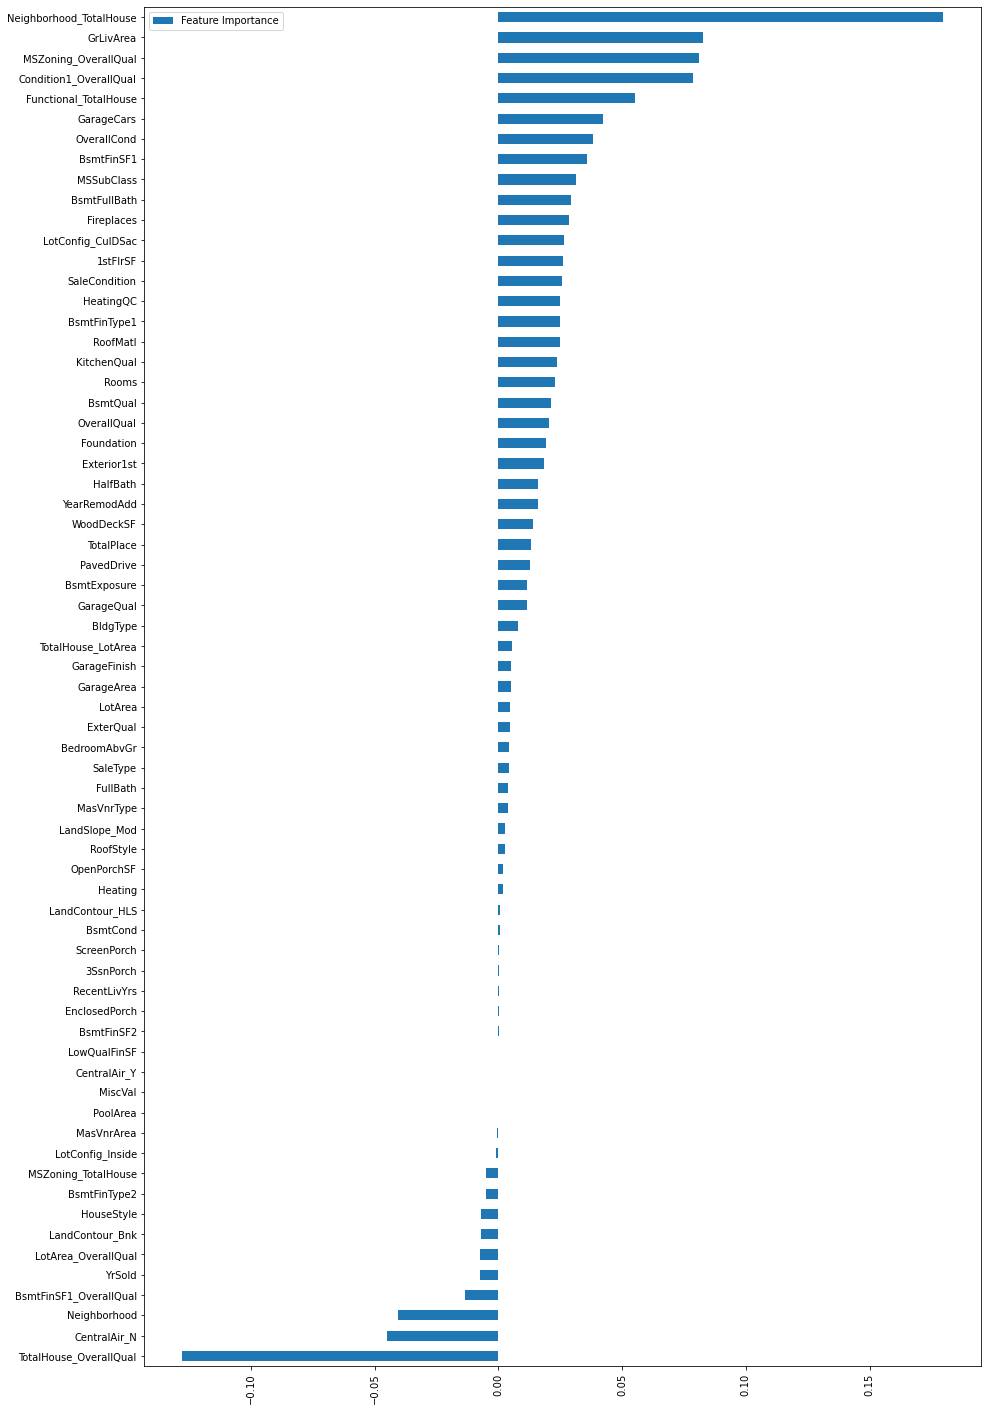

In [558]:
# 各个特征的权重
lasso=Lasso(alpha=0.001)
lasso.fit(f_train, np.log(saleprice))
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=f_train.columns)

FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [559]:
f_train.to_csv('f_train.csv', index=False)
f_test.to_csv('f_test.csv', index=False)

In [560]:
# PCA 去除共线性但这里没有降维
pca = PCA(n_components=len(f_train.columns))
X = pca.fit_transform(f_train.values)
X_submit = pca.fit_transform(f_test.values)
y = np.log(saleprice)

In [561]:
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    return rmse

In [562]:
models = [
    LinearRegression(),
    Ridge(),
    Lasso(alpha=0.01,max_iter=10000),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR(),
    LinearSVR(),
    ElasticNet(alpha=0.001,max_iter=10000),
    SGDRegressor(max_iter=1000,tol=1e-3),
    BayesianRidge(),
    KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5),
    ExtraTreesRegressor(),
    XGBRegressor()
]

In [563]:
names = ["LR", "Ridge", "Lasso", "RF", "GBR", "SVR", "LinSVR", "Ela","SGD","Bay","Ker","Extra","Xgb"]
for name, model in zip(names, models):
    score = rmse_cv(model, X, y)
    print("{}: {:.6f}, {:.4f}".format(name,score.mean(),score.std()))

LR: 0.134977, 0.0259
Ridge: 0.133623, 0.0244
Lasso: 0.144049, 0.0260
RF: 0.152916, 0.0111
GBR: 0.140685, 0.0097
SVR: 0.318863, 0.0119
LinSVR: 0.617231, 0.5849
Ela: 0.135005, 0.0265
SGD: 59134501940561.515625, 35305213929162.1641
Bay: 0.133894, 0.0219
Ker: 46.260457, 65.8572
Extra: 0.149033, 0.0089
Xgb: 0.155845, 0.0121


In [564]:
class grid():
    def __init__(self,model):
        self.model = model
    
    def grid_get(self,X,y,param_grid):
        grid_search = GridSearchCV(self.model,param_grid,cv=5, scoring="neg_mean_squared_error")
        grid_search.fit(X,y)
        print(grid_search.best_params_, np.sqrt(-grid_search.best_score_))
        grid_search.cv_results_['mean_test_score'] = np.sqrt(-grid_search.cv_results_['mean_test_score'])
        print(pd.DataFrame(grid_search.cv_results_)[['params','mean_test_score','std_test_score']])

In [565]:
grid(Lasso()).grid_get(X, y, {'alpha': [0.0004,0.0005,0.0007,0.0006,0.0009,0.0008],'max_iter':[10000]})

{'alpha': 0.0004, 'max_iter': 10000} 0.13727834560578545
                                 params  mean_test_score  std_test_score
0  {'alpha': 0.0004, 'max_iter': 10000}         0.137278        0.008107
1  {'alpha': 0.0005, 'max_iter': 10000}         0.137591        0.008132
2  {'alpha': 0.0007, 'max_iter': 10000}         0.138210        0.008094
3  {'alpha': 0.0006, 'max_iter': 10000}         0.137885        0.008115
4  {'alpha': 0.0009, 'max_iter': 10000}         0.138385        0.007926
5  {'alpha': 0.0008, 'max_iter': 10000}         0.138283        0.008011


In [566]:
grid(Ridge()).grid_get(X, y, {'alpha':[35,40,45,50,55,60,65,70,80,90]})

{'alpha': 35} 0.1369985183948627
          params  mean_test_score  std_test_score
0  {'alpha': 35}         0.136999        0.006379
1  {'alpha': 40}         0.137187        0.006414
2  {'alpha': 45}         0.137359        0.006450
3  {'alpha': 50}         0.137518        0.006487
4  {'alpha': 55}         0.137665        0.006524
5  {'alpha': 60}         0.137803        0.006560
6  {'alpha': 65}         0.137932        0.006595
7  {'alpha': 70}         0.138054        0.006629
8  {'alpha': 80}         0.138278        0.006694
9  {'alpha': 90}         0.138482        0.006755


In [567]:
grid(SVR()).grid_get(X, y, {'C':[11,12,13,14,15],'kernel':["rbf"],"gamma":[0.0003,0.0004],"epsilon":[0.008,0.009]})

{'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, 'kernel': 'rbf'} 0.17521847082123632
                                               params  mean_test_score  \
0   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.175230   
1   {'C': 11, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.177823   
2   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.175218   
3   {'C': 11, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.177866   
4   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.175269   
5   {'C': 12, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.177888   
6   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.175284   
7   {'C': 12, 'epsilon': 0.009, 'gamma': 0.0004, '...         0.177920   
8   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0003, '...         0.175359   
9   {'C': 13, 'epsilon': 0.008, 'gamma': 0.0004, '...         0.177942   
10  {'C': 13, 'epsilon': 0.009, 'gamma': 0.0003, '...         0.175368   
11  {'C': 13, 'epsilon': 0.009

In [568]:
param_grid={'alpha':[0.2,0.3,0.4,0.5], 'kernel':["polynomial"], 'degree':[3],'coef0':[0.8,1,1.2]}
grid(KernelRidge()).grid_get(X,y,param_grid)

{'alpha': 0.2, 'coef0': 1.2, 'degree': 3, 'kernel': 'polynomial'} 15439.972855316284
                                               params  mean_test_score  \
0   {'alpha': 0.2, 'coef0': 0.8, 'degree': 3, 'ker...     19647.316272   
1   {'alpha': 0.2, 'coef0': 1, 'degree': 3, 'kerne...     17356.815907   
2   {'alpha': 0.2, 'coef0': 1.2, 'degree': 3, 'ker...     15439.972855   
3   {'alpha': 0.3, 'coef0': 0.8, 'degree': 3, 'ker...     19678.135620   
4   {'alpha': 0.3, 'coef0': 1, 'degree': 3, 'kerne...     17388.075860   
5   {'alpha': 0.3, 'coef0': 1.2, 'degree': 3, 'ker...     15471.284830   
6   {'alpha': 0.4, 'coef0': 0.8, 'degree': 3, 'ker...     19706.923560   
7   {'alpha': 0.4, 'coef0': 1, 'degree': 3, 'kerne...     17417.066451   
8   {'alpha': 0.4, 'coef0': 1.2, 'degree': 3, 'ker...     15500.147491   
9   {'alpha': 0.5, 'coef0': 0.8, 'degree': 3, 'ker...     19733.036780   
10  {'alpha': 0.5, 'coef0': 1, 'degree': 3, 'kerne...     17443.267474   
11  {'alpha': 0.5, 'coef0':

In [569]:
grid(ElasticNet()).grid_get(X,y,{'alpha':[0.0005,0.0008,0.004,0.005],'l1_ratio':[0.08,0.1,0.3,0.5,0.7],'max_iter':[10000]})

{'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter': 10000} 0.13607043627833543
                                               params  mean_test_score  \
0   {'alpha': 0.0005, 'l1_ratio': 0.08, 'max_iter'...         0.136203   
1   {'alpha': 0.0005, 'l1_ratio': 0.1, 'max_iter':...         0.136225   
2   {'alpha': 0.0005, 'l1_ratio': 0.3, 'max_iter':...         0.136405   
3   {'alpha': 0.0005, 'l1_ratio': 0.5, 'max_iter':...         0.136669   
4   {'alpha': 0.0005, 'l1_ratio': 0.7, 'max_iter':...         0.137050   
5   {'alpha': 0.0008, 'l1_ratio': 0.08, 'max_iter'...         0.136070   
6   {'alpha': 0.0008, 'l1_ratio': 0.1, 'max_iter':...         0.136125   
7   {'alpha': 0.0008, 'l1_ratio': 0.3, 'max_iter':...         0.136591   
8   {'alpha': 0.0008, 'l1_ratio': 0.5, 'max_iter':...         0.137235   
9   {'alpha': 0.0008, 'l1_ratio': 0.7, 'max_iter':...         0.137769   
10  {'alpha': 0.004, 'l1_ratio': 0.08, 'max_iter':...         0.136827   
11  {'alpha': 0.004, 'l1_ratio': 0.1,

In [570]:
lr = LinearRegression()
ri = Ridge(alpha=35)
la = Lasso(alpha=0.0004,max_iter=10000)
rf = RandomForestRegressor()
gbdt = GradientBoostingRegressor()
el = ElasticNet(alpha=0.0008, l1_ratio=0.08, max_iter=10000)
ex = ExtraTreesRegressor()
xgb = XGBRegressor()

In [571]:
# Ensemble models

In [572]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)
        
    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))
        
        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])
        
        self.meta_model.fit(oof_train,y)
        return self
    
    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1) 
                                      for single_model in self.saved_model]) 
        return self.meta_model.predict(whole_test)
    
    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [573]:
# Stacking method
a = SimpleImputer().fit_transform(X)
b = SimpleImputer().fit_transform(y).ravel()

stack_model = stacking(mod=[lr, ri, la, rf, gbdt, el, ex],meta_model=xgb)
stack_model.fit(a, b)
f_pred = np.exp(stack_model.predict(X_submit))

In [574]:
# Submission
out = pd.DataFrame(np.concatenate([test.Id.values.reshape(-1,1), f_pred.reshape(-1,1)], axis=1), columns=['Id', 'SalePrice'])
out['Id'] = out.Id.astype('int')
out.to_csv('submission.csv', index=False)